In [4]:
import torch
import os
from torch import nn
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import json
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset, TensorDataset
import time
from ast import literal_eval
import torch.autograd as autograd
from torch.utils.data import Dataset


In [5]:

'''---Create data loader----'''

class MovieDataset(Dataset):
    def __init__(self, filename):
        super().__init__()
        self.df = pd.read_csv(filename, converters={'input_x': literal_eval})


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # load the input features
        input_x = self.df['input_x'].iloc[index]
        label = self.df['Label'].iloc[index]

        return torch.tensor(input_x), torch.tensor(label,dtype=torch.float)


In [6]:
## download the pretrain embedding
def _read_glove_embedding(glove_file):
    '''Fun:read embedding from pre-train by glove
    '''
    ## map word to embedding
    word2embedding = dict()
    with open(glove_file,"r") as f:
        for num,line in enumerate(f):
            values = line.split()
            word = values[0]
            emb = np.array(values[1:], dtype='float32')
            word2embedding[word] = emb
    # Return a dictionary mapping from each word to d-dimension vector from Glove
    return word2embedding


def _get_embedding(glove_file,tokens2index,embed_dim=200):
    """Fun:get the embedding matrix for our vocabulary
    """
    ##load glove embedding to embedding matrix
    word2embedding = _read_glove_embedding(glove_file)
    embedding_matrix = np.zeros((len(tokens2index), embed_dim))
    for word, i in tokens2index.items():
        embedding_vector = word2embedding.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    # Return embedding matrix
    return torch.FloatTensor(embedding_matrix)

In [7]:
class LSTMModel(nn.Module):
    """
    LSTM model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, embedding_matrix,\
        hidden_dim, n_layers, input_len, pretrain=False):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size  # y_out size = 1
        self.n_layers = n_layers   # layers of LSTM
        self.hidden_dim = hidden_dim  # hidden dim of LSTM
        self.input_len = input_len # len of input features

        ## set up pre-train embeddings. if true, load pretrain-embedding from GloVe
        if pretrain:
            # print("import glove embedding to nn.Embedding now")
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix,freeze=False)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.init_weights()
        ##-------------------------------------------
        ## Q4: write the code to define LSTM model
        ##-------------------------------------------
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        ## dropout layer
        self.dropout = nn.Dropout(0.3)

        ## max pool
        self.pool = nn.MaxPool1d(self.input_len)

        ## linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()


    ## initialize the weights
    def init_weights(self):
        """
        Initializes some parameters with values from the uniform distribution, for easier convergence.
        """
        self.embedding.weight.data.uniform_(-0.1, 0.1)

    ## initial hidden state and cell state
    def _init_hidden(self, batch_size, device):
        return(autograd.Variable(torch.randn(self.n_layers, batch_size, self.hidden_dim)).to(device),
                autograd.Variable(torch.randn(self.n_layers, batch_size, self.hidden_dim)).to(device)
                )


    ## feed input x into LSTM model for training/testing
    def forward(self, x, device):
        batch_size = x.size(0)
        hidden_cell = self._init_hidden(batch_size, device)

        ## feed words to get embeddings
        embeds = self.embedding(x)

        ## hidden_cell: (hidden, cell) where hidden=layer * batch * dim
        lstm_out, _ = self.lstm(embeds, hidden_cell)
        # print("size: ", lstm_out.size())  #2*100*50

        ## permute the output dim
        lstm_out = lstm_out.permute(0,2,1)

        out = self.pool(lstm_out)
        # print("pool size:", out.size())

        out = out.view(out.size(0),-1)

        ## feed into linear layer
        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = out[:,0]

        return out


In [8]:
def may_make_dir(path):
    """
    Args:
        path: a dir, or result of `os.path.dirname(os.path.abspath(file_path))`
    Note:
        `os.path.exists('')` returns `False`, while `os.path.exists('.')` returns `True`!
    """
    # This clause has mistakes:
    # if path is None or '':

    if path in [None, '']:
        return
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
'''save checkpoint'''
def _save_checkpoint(ckp_file_path, model, epoches, global_step, optimizer):
    checkpoint = {'epoch': epoches,
                'global_step': global_step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}
    may_make_dir(os.path.dirname(os.path.abspath(ckp_file_path)))
    torch.save(checkpoint, ckp_file_path)

In [11]:
def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    print("device: ", device)

    # Parameters
    Batch_size = 64
    n_layers = 2
    input_len = 150
    embedding_dim = 300 # As we are using glove embedding 300-D vectors
    hidden_dim = 200
    mode = 'train'
    load_cpt = False #True
    ckp_path = 'checkpoint'
    resume_step = 0 # for resuming the model weight (only use when load_ckpt is True)
    
    # binary cross entropy
    output_size = 1
    num_epoches = 100
    learning_rate = 0.001
    clip = 5
    embedding_matrix = None

    pretrain = True # Load GloVe embedding matrix
    if pretrain:
        glove_file = 'data/glove.6B/glove.6B.300d.txt' # change this to the correct path of the Glove file that contain the vector we want to use
        
    training_set = MovieDataset('data/training_data.csv')
    training_generator = DataLoader(training_set,batch_size=Batch_size,shuffle=True,num_workers=1)
    test_set = MovieDataset('data/test_data.csv')
    test_generator = DataLoader(test_set,batch_size=Batch_size,shuffle=False,num_workers=1)

    # Read tokens & Load pretrained embedding matrix
    with open('data/tokens2index.json', 'r') as f:
        tokens2index = json.load(f)
    vocab_size = len(tokens2index)

    if pretrain:
        embedding_matrix = _get_embedding(glove_file,tokens2index,embedding_dim)

    # Model training
    model = LSTMModel(vocab_size, output_size, embedding_dim, embedding_matrix,hidden_dim, n_layers, input_len,pretrain)
    model.to(device)

    optimizer = optim.Adam(model.parameters(),lr=learning_rate)
    criterion = nn.BCELoss()

    # load checkpoint
    if load_cpt:
        print("*"*10+'loading checkpoint'+'*'*10)
        ckp_file_path = os.path.join(ckp_path, 'step_{}.pt'.format(resume_step))
        # check if the ckpt exist
        assert os.path.exists(ckp_file_path), 'The ckpt path is not exist!'
        checkpoint = torch.load(ckp_file_path)
        ## load parameters such as W and b to models
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoches = checkpoint['epoch']

    ## model training
    print('*'*89)
    print('start model training now')
    print('*'*89)
    if mode == 'train':
        model.train()
        global_step = 0
        loss_list = []
        loss_per_epoch = []
        loss_history = []
        for epoches in range(num_epoches):
            for x_batch, y_labels in training_generator:
                global_step += 1
                # print("step: ", global_step)
                x_batch, y_labels = x_batch.to(device), y_labels.to(device)
                y_out = model(x_batch, device)

                ## loss fun
                loss = criterion(y_out, y_labels)
                
                loss_list.append(loss.item())
                loss_per_epoch.append(loss.item())

                ## back propagation
                optimizer.zero_grad()
                loss.backward()
                ## clip_grad_norm helps prevent the exploding gradient problem in LSTMs.
                nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()

                if global_step % 50 == 0:
                    ## y predict label
                    y_pred_label = torch.round(y_out)
                    print("step:{0} loss: {1}".format(global_step,np.mean(loss_list)))
                    loss_list = []
        
            loss_history.append(np.mean(loss_per_epoch)) 
            
            # save checkpoint for each epoch
            print("*** save checkpoint ****")
            ckpt_file_path = os.path.join(ckp_path, 'step_{}.pt'.format(global_step))
            # ckp_path = 'checkpoint/step_{}.pt'.format(global_step)
            _save_checkpoint(ckpt_file_path, model, epoches, global_step, optimizer)   

    # Plotting the loss
    plt.figure()
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()
    # Plot loss after training
    
    ## model testing
    print("----model testing now----")
    accy_count_total = 0
    total_count = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_labels in test_generator:
            x_batch, y_labels = x_batch.to(device), y_labels.to(device)
            y_out = model(x_batch, device)
            ## predict label 1 or 0
            y_pred = torch.round(y_out)
            # print(y_pred)
            accy_count = (y_pred==y_labels).sum().item()
            accy_count_total += accy_count
            total_count += len(y_labels)
        ## overall accuracy
        accy = accy_count_total/total_count*100
        print("test accuracy: ", accy)

*****************************************************************************************
start model training now
*****************************************************************************************
step:50 loss: 0.6879158818721771
step:100 loss: 0.5474800729751587
step:150 loss: 0.4414543652534485
step:200 loss: 0.42285697281360624
step:250 loss: 0.39608989030122754
step:300 loss: 0.3731684562563896
step:350 loss: 0.3449834924936295
step:400 loss: 0.30728959262371064
step:450 loss: 0.3116663745045662
step:500 loss: 0.28051521360874176
step:550 loss: 0.2926803186535835
step:600 loss: 0.30002873033285143
step:650 loss: 0.3008412256836891
step:700 loss: 0.2148407918214798
step:750 loss: 0.2065829226374626
step:800 loss: 0.23087890431284905
step:850 loss: 0.23433969259262086
step:900 loss: 0.23183392137289047
step:950 loss: 0.22074613481760025
step:1000 loss: 0.18499259158968925
step:1050 loss: 0.13070342965424062
step:1100 loss: 0.13927300065755843
step:1150 loss: 0.147724453955888

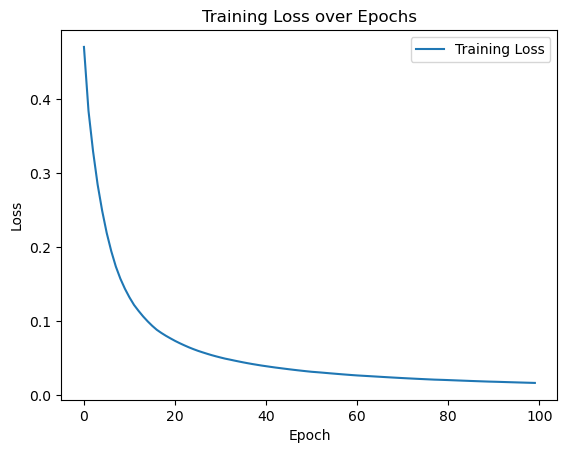

----model testing now----
test accuracy:  81.96


In [12]:
if __name__ == '__main__':
    main()